# Motivation

This notebook is a practice of sentiment analysis using Keras on the US airline twitter dataset available at https://www.kaggle.com/crowdflower/twitter-airline-sentiment/downloads/twitter-airline-sentiment.zip/2

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np

In [2]:
df = pd.read_csv("Tweets.csv")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
tweet_id                        14640 non-null int64
airline_sentiment               14640 non-null object
airline_sentiment_confidence    14640 non-null float64
negativereason                  9178 non-null object
negativereason_confidence       10522 non-null float64
airline                         14640 non-null object
airline_sentiment_gold          40 non-null object
name                            14640 non-null object
negativereason_gold             32 non-null object
retweet_count                   14640 non-null int64
text                            14640 non-null object
tweet_coord                     1019 non-null object
tweet_created                   14640 non-null object
tweet_location                  9907 non-null object
user_timezone                   9820 non-null object
dtypes: float64(2), int64(2), object(11)
memory usage: 1.7+ MB


In [4]:
# I want to only look at the text data for analysing the sentiment and will restrict myself to classification of positive/neutral/negative

columns_to_keep = [
    "airline_sentiment",
    "text"
]

df = df[columns_to_keep]

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 2 columns):
airline_sentiment    14640 non-null object
text                 14640 non-null object
dtypes: object(2)
memory usage: 228.9+ KB


In [6]:
df.head()

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...


In [7]:
df["airline_sentiment"].value_counts()

negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64

In [8]:
# None of the rows contain nulls, however the classes of the target variable are unevenly distributed

## Data Cleaning and encoding

1) The target variable needs to be encoded as an int

2) The text needs to be cleaned so it is lower case and only contains alpha-numerica characters

## NOTE: Emoji's contain interesting information and are emotional qualifiers

Sentiment for "Ryanair your customer service is great *laughing face* is completely wrong if the emoji is removed

In [9]:
# target variable encoding to int
sentiments = {
    "negative": 0,
    "neutral" : 1,
    "positive": 2,
}

df["sentiment"] = df["airline_sentiment"].apply(lambda x: sentiments[x])

In [10]:
# text cleaning

In [11]:
#import string
#lookup_table = str.maketrans({key: None for key in string.punctuation})

In [12]:
from nltk.tokenize import word_tokenize

def clean_text(text):
    tokens = word_tokenize(text)
    return " ".join([t for t in tokens if t.isalpha()]).strip().replace("\n", " ").lower()

In [13]:
df["cleaned_text"] = df["text"].apply(clean_text)

In [14]:
df["cleaned_text"].head()

0                     virginamerica what dhepburn said
1    virginamerica plus you added commercials to th...
2    virginamerica i did today must mean i need to ...
3    virginamerica it really aggressive to blast ob...
4    virginamerica and it a really big bad thing ab...
Name: cleaned_text, dtype: object

### What is the average number of words in the tweets?

This will be useful in deciding the length of the sequences for the LSTM in the model

In [15]:
df["number_of_words"] = df["cleaned_text"].apply(lambda x: len(x.split(" ")))
                                         

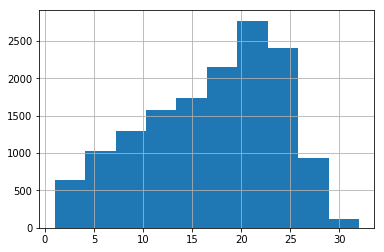

In [16]:
df["number_of_words"].hist()

In [17]:
maximum_words_in_a_tweet = df["number_of_words"].max()
maximum_words_in_a_tweet

32

# How often do the tweets have emoji's in?

In [21]:
import emoji

def extract_emojis(str):
    return ''.join(c for c in str if c in emoji.UNICODE_EMOJI)

In [22]:
df["emojis"] = df["text"].apply(extract_emojis)

In [23]:
df["emojis"].value_counts()

         14147
😊           18
👍           16
😒           15
😉           14
         ...  
💩            1
😅            1
😩😂😂😂😂        1
❄❄❄          1
😍😍😍          1
Name: emojis, Length: 236, dtype: int64

In [ ]:
# There aren't actually that many emojis so it wouldn't give much information?

# Create train and test data

In [18]:
X = df["cleaned_text"].values
y = df["sentiment"].values

In [19]:
from sklearn.model_selection import train_test_split

# TODO: do i need to stratify to maintain the distribution of the target variable.
X_train, X_test, y_train, y_test = train_test_split(X, y, ,stratify=y, test_size=0.2) 

# Word vector embeddings

1) Create a lookup table for the tokens and their vectors using a fasttext model, included padding and unknown (out-of-vocabulary) tokens and vectors for them

2) Tokenize the text into a list of tokens

3) pass the lookup table to the embedding layer in the model so it can perform the lookup for the vector for each token,

In [20]:
import fasttext

en_model = fasttext.load_model("../fasttext/cc.en.300.bin")

In [21]:
embedding_dimension = en_model.get_dimension()

In [22]:
# keras uses index 0 for padding, so first token in words will be looked up in the matrix, actual token doesn't matter
# specifiying the unknown token so then when they're tokenized it uses it and looks up the correct token in the weights matrix
padding_token = "<pad>"
unknown_token = "<unk>"

words = [padding_token, unknown_token] + en_model.get_words()

In [23]:
word_2_index = {word: index for index, word in enumerate(words)}

In [24]:
# Lookup table for keras embedding layer

weights = np.zeros((len(word_2_index), embedding_dimension))

In [25]:
# Populate the matrix with the vectors from fasttext, if unknown tokens put random vector, if padding set to 0-vector.

for word, i in word_2_index.items():
    if word == "<pad>":
        vec = np.zeros(embedding_dimension) # vector of zeros for padding
    elif word == "<unk>":
        vec = np.random.uniform(low=-1.0, high=1.0, size=(embedding_dimension,)) # random vector for unknown words

    #elif word in en_model.get_words():
    #    vec = en_model.get_word_vector(word)
    #else:
    #    # word not in fasttext corpus, return vector for unknown token
    #    vec = np.random.uniform(low=-1.0, high=1.0, size=(embedding_dimension,)) # random vector for unknown words
    
    else:
        vec = en_model.get_word_vector(word)
    weights[i] = vec
    
print(weights.shape)

(2000002, 300)


In [26]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(oov_token=unknown_token)

Using TensorFlow backend.


In [27]:
tokenizer.fit_on_texts(X_train) 

In [28]:
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [29]:
# How many words were found in the tokenizer? These would be a lot less than the total vocabulary for the fasttext model

# I did use this for the weights matrix but it is relying on the train set containing all the tokens we would see in the 
# test set/ any later incoming data
len(tokenizer.word_index)

10208

In [30]:
print(df["cleaned_text"].values[0])
print(tokenizer.texts_to_sequences([df["cleaned_text"].values[0]]))

virginamerica what dhepburn said
[[76, 49, 9291, 222]]


### Target variable encoding

Need to encode to categorical variable for multi class classification

In [31]:
number_of_target_classes = len(df["sentiment"].unique())

In [32]:
from keras.utils import to_categorical

y_cat_train = to_categorical(y_train, num_classes=number_of_target_classes)
y_cat_test = to_categorical(y_test, num_classes=number_of_target_classes)

## Dealing with class imbalance

add class weights for the classifier to improve performance

In [33]:
from sklearn.utils import compute_class_weight

class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=np.argmax(y_cat_train, axis=1))
class_weights

array([0.53464804, 1.56285028, 2.041841  ])

### Padding for the model

Tweets have a maximum character length of 140 so the maxlength of the sequences going into the model can be of length 140 with post padding to extend any tweets shorter than the maximum length

In [34]:
from keras.preprocessing.sequence import pad_sequences

max_length = maximum_words_in_a_tweet # use the max tweet size we've seen in the data to minimize padding

X_train_pad = pad_sequences(X_train, max_length, padding="post")
X_test_pad = pad_sequences(X_test, max_length, padding="post")

In [35]:
X_train_pad.shape

(11712, 32)

# Model

In [36]:
from keras.models import Model
from keras import layers
import keras.backend as K

In [37]:
embedding_dimensions = 300 # number of dimensions for the word vector embeddings
number_of_classes = 3 # positive/neutral/negative
dropout_ratio = 0.2 # % of neurons to drop out to stop overfitting
vocabulary_size = len(words) # the number of words found in the train set which have been encoded

In [79]:
K.clear_session() # Memory issues if don't restart session

inputs = layers.Input(shape=(max_length,))

embedding = layers.Embedding(input_dim=vocabulary_size, 
                      output_dim=embedding_dimensions, 
                      input_length=max_length,
                      weights=[weights],
                      trainable=False, # Don't want it overfitting, went to use this as a lookup to the fasttext word vectors
                     )(inputs)

# 32 cells as this is the maximum word length of a tweet
# Bidirectional so 64

lstm = layers.LSTM(maximum_words_in_a_tweet, dropout=dropout_ratio, recurrent_dropout=dropout_ratio, return_sequences=True)
x = layers.Bidirectional(lstm)(embedding)

# worked as a way to flatten the data
#x = layers.LSTM(10)(x)

# i'm returning the sequences so i can use the convolutions after this but would it be better to reshape the vector to have a single channel
#lstm = layers.LSTM(maximum_words_in_a_tweet, dropout=dropout_ratio, recurrent_dropout=dropout_ratio, return_sequences=True)
#x = layers.Bidirectional(lstm)(embedding)
#x = layers.Reshape((maximum_words_in_a_tweet*2, 1))(x)

x = layers.Dropout(dropout_ratio)(x)

x = layers.Conv1D(16, 5, padding="same")(x) # 5 strides to check for large scale strcture
x = layers.MaxPooling1D(padding="same")(x)
x = layers.Activation("tanh")(x)
x = layers.Dropout(dropout_ratio)(x)

x = layers.SpatialDropout1D(dropout_ratio)(x)

x = layers.Conv1D(16, 2, padding="same")(x) # 2 strides to check for fine structure 
x = layers.MaxPooling1D(padding="same")(x)
x = layers.Activation("tanh")(x)
x = layers.Dropout(dropout_ratio)(x)

x = layers.SpatialDropout1D(dropout_ratio)(x)

x = layers.Flatten()(x)
x = layers.Dense(32, activation="relu")(x)
x = layers.Dropout(dropout_ratio)(x)
outputs = layers.Dense(number_of_classes, activation="softmax")(x)
model = Model(inputs=inputs, outputs=outputs)

In [80]:
results = model.predict(X_train_pad)
results.shape

(11712, 3)

In [81]:
from keras.optimizers import RMSprop
model.compile(RMSprop(lr=0.001),
             "categorical_crossentropy",
             metrics=["accuracy"])

In [82]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 32, 300)           600000600 
_________________________________________________________________
bidirectional_1 (Bidirection (None, 32, 64)            85248     
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 64)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 32, 16)            5136      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 16, 16)            0         
_________________________________________________________________
activation_1 (Activation)    (None, 16, 16)            0         
__________

In [83]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor="val_loss",patience=1)

In [84]:
model.fit(X_train_pad, 
          y_cat_train,
          batch_size=16,
          class_weight=class_weights, # use class weights to deal with imbalanced classes
          epochs=20,
          callbacks=[early_stopping],
          validation_split=0.2)

Train on 9369 samples, validate on 2343 samples
Epoch 1/20
9369/9369 [==============================] - 76s 8ms/step - loss: 0.8266 - acc: 0.6554 - val_loss: 0.7292 - val_acc: 0.6987
Epoch 2/20
9369/9369 [==============================] - 74s 8ms/step - loss: 0.7541 - acc: 0.6980 - val_loss: 0.6958 - val_acc: 0.7226
Epoch 3/20
9369/9369 [==============================] - 75s 8ms/step - loss: 0.7259 - acc: 0.7132 - val_loss: 0.6733 - val_acc: 0.7243
Epoch 4/20
9369/9369 [==============================] - 75s 8ms/step - loss: 0.6989 - acc: 0.7213 - val_loss: 0.6687 - val_acc: 0.7281
Epoch 5/20
9369/9369 [==============================] - 76s 8ms/step - loss: 0.6868 - acc: 0.7287 - val_loss: 0.6774 - val_acc: 0.7341


In [85]:
y_pred = model.predict(X_test_pad)

In [86]:
y_pred[0]

array([0.5771884 , 0.38622266, 0.03658898], dtype=float32)

In [87]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_cat_test.argmax(axis=1), y_pred.argmax(axis=1))

array([[1821,   37,   18],
       [ 440,  145,   16],
       [ 272,   32,  147]])

In [88]:
from sklearn.metrics import accuracy_score
accuracy_score(y_cat_test.argmax(axis=1), y_pred.argmax(axis=1))

0.7216530054644809

In [89]:
from pycm import ConfusionMatrix
matrix = ConfusionMatrix(y_cat_test.argmax(axis=1), y_pred.argmax(axis=1))
print(matrix)

ImportError: No module named 'pycm'